## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2
import tensorflow as tf
from numba import cuda
cuda.select_device(0)
cuda.close()
import itertools

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
## 超參數設定

LEARNING_RATE = 1e-3
OPTIMIZER = 'SGD'
EPOCHS = 50
BATCH_SIZE = 256
REGULARIZER = ['L1','L2', 'L1_L2']
REG_EXP = [1e-2, 1e-4]

In [10]:
def build_mlp(regularizer, reg_ratio, input_shape, output_units=y_train.shape[-1], num_neurons=[256, 128, 64, 32]):

    input_layer = keras.layers.Input(input_shape)
    
    switcher = {'L1': l1(reg_ratio), 'L2': l2(reg_ratio), 'L1_L2': l1_l2(reg_ratio)}

    kernel_regularizer = switcher.get(regularizer)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation='relu',
                                       name='hidden_layers'+str(i+1),kernel_regularizer=kernel_regularizer)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation='relu', 
                                   name='hidden_layers'+str(i+1),kernel_regularizer=kernel_regularizer)(x)   

    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])

    return model

In [11]:
def model_fitting(regularizer, reg_ratio, learning_rate=LEARNING_RATE, 
                  optimizer=OPTIMIZER, epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=x_train.shape[1:]):

    keras.backend.clear_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)

    

    model = build_mlp(regularizer=regularizer, reg_ratio=reg_ratio, input_shape=input_shape)
    model.summary()

    selector = {'SGD': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'RMSprop': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'AdaGrad': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'Adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}

    optimizer = selector.get(optimizer)

    

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    history = model.fit(x_train, y_train, epochs=epochs, 
                        batch_size=batch_size,validation_data=(x_test, y_test), 
                        shuffle=False, verbose=2)

    sess.close()

    return history

In [15]:
results = {}

for regu, ratio in itertools.product(REGULARIZER, REG_EXP):
   
    history = model_fitting(regularizer=regu, reg_ratio=ratio)

    name_tag = f'{regu}, ratio={ratio}'

    results[name_tag] = {'train_loss': history.history['loss'],
                         'valid_loss': history.history['val_loss'],
                         'train_acc': history.history['acc'],
                         'valid_acc': history.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layers1 (Dense)       (None, 256)               786688    
_________________________________________________________________
hidden_layers2 (Dense)       (None, 128)               32896     
_________________________________________________________________
hidden_layers3 (Dense)       (None, 64)                8256      
_________________________________________________________________
hidden_layers4 (Dense)       (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 830,250
Trainable params: 830,250
Non-trainable params: 0
_________________________________________________________________
Trai

Epoch 21/50
 - 3s - loss: 2.7218 - acc: 0.5313 - val_loss: 2.7970 - val_acc: 0.5044
Epoch 22/50
 - 3s - loss: 2.6827 - acc: 0.5368 - val_loss: 2.7722 - val_acc: 0.5055
Epoch 23/50
 - 3s - loss: 2.6482 - acc: 0.5416 - val_loss: 2.7373 - val_acc: 0.5105
Epoch 24/50
 - 3s - loss: 2.6120 - acc: 0.5458 - val_loss: 2.7127 - val_acc: 0.5098
Epoch 25/50
 - 3s - loss: 2.5767 - acc: 0.5517 - val_loss: 2.6835 - val_acc: 0.5106
Epoch 26/50
 - 3s - loss: 2.5425 - acc: 0.5554 - val_loss: 2.6603 - val_acc: 0.5126
Epoch 27/50
 - 3s - loss: 2.5084 - acc: 0.5588 - val_loss: 2.6284 - val_acc: 0.5178
Epoch 28/50
 - 3s - loss: 2.4743 - acc: 0.5641 - val_loss: 2.6098 - val_acc: 0.5166
Epoch 29/50
 - 3s - loss: 2.4438 - acc: 0.5679 - val_loss: 2.5879 - val_acc: 0.5179
Epoch 30/50
 - 3s - loss: 2.4120 - acc: 0.5723 - val_loss: 2.5632 - val_acc: 0.5183
Epoch 31/50
 - 3s - loss: 2.3818 - acc: 0.5754 - val_loss: 2.5467 - val_acc: 0.5173
Epoch 32/50
 - 3s - loss: 2.3513 - acc: 0.5785 - val_loss: 2.5222 - val_acc:

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 3s - loss: 9.4333 - acc: 0.2003 - val_loss: 8.7436 - val_acc: 0.2633
Epoch 2/50
 - 3s - loss: 8.1686 - acc: 0.3052 - val_loss: 7.6429 - val_acc: 0.3356
Epoch 3/50
 - 3s - loss: 7.1961 - acc: 0.3440 - val_loss: 6.7758 - val_acc: 0.3517
Epoch 4/50
 - 3s - loss: 6.3995 - acc: 0.3606 - val_loss: 6.0466 - val_acc: 0.3632
Epoch 5/50
 - 3s - loss: 5.7263 - acc: 0.3723 - val_loss: 5.4281 - val_acc: 0.3738
Epoch 6/50
 - 3s - loss: 5.1533 - acc: 0.3826 - val_loss: 4.8999 - val_acc: 0.3843
Epoch 7/50
 - 3s - loss: 4.6648 - acc: 0.3921 - val_loss: 4.4506 - val_acc: 0.3930
Epoch 8/50
 - 3s - loss: 4.2486 - acc: 0.3993 - val_loss: 4.0675 - val_acc: 0.4007
Epoch 9/50
 - 3s - loss: 3.8932 - acc: 0.4061 - val_loss: 3.7407 - val_acc: 0.4058
Epoch 10/50
 - 3s - loss: 3.5892 - acc: 0.4120 - val_loss: 3.4612 - val_acc: 0.4105
Epoch 11/50
 - 3s - loss: 3.3290 - acc: 0.4170 - val_loss: 3.2220 - val_acc: 0.4143
Epoch 12/50
 - 3s - loss: 3.1064 - 

 - 3s - loss: 1.2036 - acc: 0.6007 - val_loss: 1.4830 - val_acc: 0.5127
Epoch 35/50
 - 3s - loss: 1.1938 - acc: 0.6043 - val_loss: 1.4845 - val_acc: 0.5127
Epoch 36/50
 - 3s - loss: 1.1833 - acc: 0.6078 - val_loss: 1.4936 - val_acc: 0.5104
Epoch 37/50
 - 3s - loss: 1.1717 - acc: 0.6115 - val_loss: 1.4924 - val_acc: 0.5105
Epoch 38/50
 - 3s - loss: 1.1604 - acc: 0.6162 - val_loss: 1.5011 - val_acc: 0.5107
Epoch 39/50
 - 3s - loss: 1.1499 - acc: 0.6201 - val_loss: 1.5016 - val_acc: 0.5111
Epoch 40/50
 - 3s - loss: 1.1427 - acc: 0.6225 - val_loss: 1.5028 - val_acc: 0.5103
Epoch 41/50
 - 3s - loss: 1.1289 - acc: 0.6282 - val_loss: 1.5044 - val_acc: 0.5112
Epoch 42/50
 - 3s - loss: 1.1253 - acc: 0.6285 - val_loss: 1.5211 - val_acc: 0.5105
Epoch 43/50
 - 3s - loss: 1.1168 - acc: 0.6314 - val_loss: 1.5173 - val_acc: 0.5069
Epoch 44/50
 - 3s - loss: 1.1020 - acc: 0.6363 - val_loss: 1.5389 - val_acc: 0.5076
Epoch 45/50
 - 3s - loss: 1.0993 - acc: 0.6366 - val_loss: 1.5482 - val_acc: 0.5054
Epoc

Epoch 4/50
 - 3s - loss: 2.8438 - acc: 0.0981 - val_loss: 2.5367 - val_acc: 0.1000
Epoch 5/50
 - 3s - loss: 2.4444 - acc: 0.0986 - val_loss: 2.3861 - val_acc: 0.1000
Epoch 6/50
 - 3s - loss: 2.3800 - acc: 0.0974 - val_loss: 2.3788 - val_acc: 0.1000
Epoch 7/50
 - 3s - loss: 2.3789 - acc: 0.0975 - val_loss: 2.3789 - val_acc: 0.1000
Epoch 8/50
 - 3s - loss: 2.3789 - acc: 0.0975 - val_loss: 2.3789 - val_acc: 0.1000
Epoch 9/50
 - 3s - loss: 2.3789 - acc: 0.0971 - val_loss: 2.3788 - val_acc: 0.1000
Epoch 10/50
 - 3s - loss: 2.3789 - acc: 0.0971 - val_loss: 2.3788 - val_acc: 0.1000
Epoch 11/50
 - 3s - loss: 2.3788 - acc: 0.0974 - val_loss: 2.3788 - val_acc: 0.1000
Epoch 12/50
 - 3s - loss: 2.3788 - acc: 0.0974 - val_loss: 2.3787 - val_acc: 0.1000
Epoch 13/50
 - 3s - loss: 2.3788 - acc: 0.0974 - val_loss: 2.3788 - val_acc: 0.1000
Epoch 14/50
 - 3s - loss: 2.3788 - acc: 0.0974 - val_loss: 2.3787 - val_acc: 0.1000
Epoch 15/50
 - 3s - loss: 2.3788 - acc: 0.0975 - val_loss: 2.3787 - val_acc: 0.100

Epoch 38/50
 - 3s - loss: 1.8505 - acc: 0.4525 - val_loss: 1.8644 - val_acc: 0.4519
Epoch 39/50
 - 3s - loss: 1.8451 - acc: 0.4531 - val_loss: 1.8617 - val_acc: 0.4537
Epoch 40/50
 - 3s - loss: 1.8406 - acc: 0.4551 - val_loss: 1.8555 - val_acc: 0.4577
Epoch 41/50
 - 3s - loss: 1.8361 - acc: 0.4567 - val_loss: 1.8528 - val_acc: 0.4561
Epoch 42/50
 - 3s - loss: 1.8324 - acc: 0.4568 - val_loss: 1.8481 - val_acc: 0.4574
Epoch 43/50
 - 3s - loss: 1.8288 - acc: 0.4576 - val_loss: 1.8432 - val_acc: 0.4542
Epoch 44/50
 - 3s - loss: 1.8254 - acc: 0.4590 - val_loss: 1.8400 - val_acc: 0.4570
Epoch 45/50
 - 3s - loss: 1.8214 - acc: 0.4606 - val_loss: 1.8409 - val_acc: 0.4563
Epoch 46/50
 - 3s - loss: 1.8188 - acc: 0.4610 - val_loss: 1.8355 - val_acc: 0.4581
Epoch 47/50
 - 3s - loss: 1.8148 - acc: 0.4626 - val_loss: 1.8337 - val_acc: 0.4575
Epoch 48/50
 - 3s - loss: 1.8117 - acc: 0.4638 - val_loss: 1.8323 - val_acc: 0.4579
Epoch 49/50
 - 3s - loss: 1.8088 - acc: 0.4647 - val_loss: 1.8299 - val_acc:

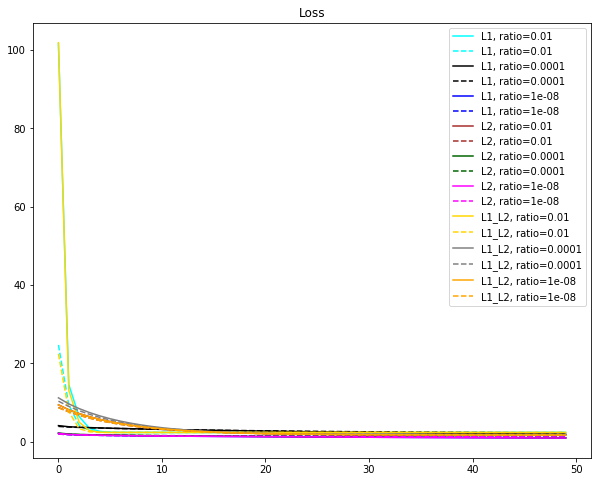

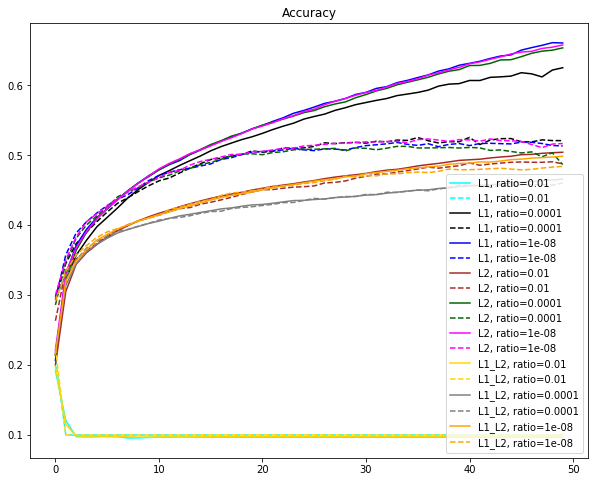

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ['aqua','black','blue','brown',
            'darkgreen','fuchsia','gold','grey',
             'orange','olive','purple','red']

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
